In [2]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
sns.set_style()
%matplotlib inline


In [ ]:
# Making data sets from images that are in folders named as their class_label

column_labels = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta']
train_dataset = image_dataset_from_directory(
    '/data/processed/train_w_labels',
    labels='inferred',
    color_mode='grayscale',
    batch_size=128,
    image_size=(70,70),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 91166 files belonging to 15 classes.


In [ ]:
val_dataset = image_dataset_from_directory(
    '/data/processed/val_w_labels',
    labels='inferred',
    color_mode='grayscale',
    batch_size=128,
    image_size=(70,70),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 7500 files belonging to 15 classes.


In [6]:
test_dataset = image_dataset_from_directory(
    '/data/processed/test_w_labels',
    labels='inferred',
    color_mode='grayscale',
    batch_size=128,
    image_size=(70,70),
    shuffle=False,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=False,
    class_names=column_labels)

Found 7500 files belonging to 15 classes.


In [7]:
# Normalizing images
normalization_layer = layers.Rescaling(1./255)
train_ds_norm = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_ds_norm = test_dataset.map(lambda x, y: (normalization_layer(x), y))
val_ds_norm = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [8]:
# Setting up model
img_width, img_height = 70, 70
epochs = 2000
batch_size = 128
n_classes = 15
input_shape= (img_width, img_height, 1)

In [9]:
# Keras model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(140, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Saving the weights for the lowest loss value 
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='data/processed/keras/final_model.keras',
        save_best_only=True,
        monitor='val_loss'
    )]

In [ ]:
# Running model
history = model.fit(
    x=train_ds_norm,
    y=None,
    validation_data= val_ds_norm,
    epochs=epochs,
    verbose="auto",
    callbacks=callbacks,
    validation_split=0.0,
    shuffle=True,
    validation_freq=1,
    batch_size = batch_size
    )

Epoch 1/2000
713/713 [==============================] - 26s 31ms/step - loss: 1.7793 - accuracy: 0.4446 - val_loss: 1.2023 - val_accuracy: 0.5936
Epoch 2/2000
713/713 [==============================] - 21s 30ms/step - loss: 1.2049 - accuracy: 0.6103 - val_loss: 1.1787 - val_accuracy: 0.5992
Epoch 3/2000
713/713 [==============================] - 21s 29ms/step - loss: 1.0660 - accuracy: 0.6569 - val_loss: 1.1009 - val_accuracy: 0.6276
Epoch 4/2000
713/713 [==============================] - 21s 30ms/step - loss: 0.9829 - accuracy: 0.6833 - val_loss: 1.0349 - val_accuracy: 0.6588
Epoch 5/2000
713/713 [==============================] - 21s 29ms/step - loss: 0.9216 - accuracy: 0.7030 - val_loss: 0.9800 - val_accuracy: 0.6841
Epoch 6/2000
713/713 [==============================] - 21s 29ms/step - loss: 0.8830 - accuracy: 0.7161 - val_loss: 0.7638 - val_accuracy: 0.7471
Epoch 7/2000
713/713 [==============================] - 20s 28ms/step - loss: 0.8549 - accuracy: 0.7252 - val_loss: 0.9409 -

In [ ]:
loss, acc = model.evaluate(test_ds_norm, y=None, verbose=2)

59/59 - 1s - loss: 0.5056 - accuracy: 0.8315 - 1s/epoch - 23ms/step


In [10]:
# Loading the best weights for this model
model.load_weights('data/processed/keras/final_model.keras')

In [ ]:
loss, acc = model.evaluate(test_ds_norm, y=None, verbose=2)

59/59 - 1s - loss: 0.4676 - accuracy: 0.8468 - 1s/epoch - 20ms/step


## 84.68 accuracy is the highest that any model has given.

In [ ]:
# Saving model
model.save('data/processed/final_model.keras')

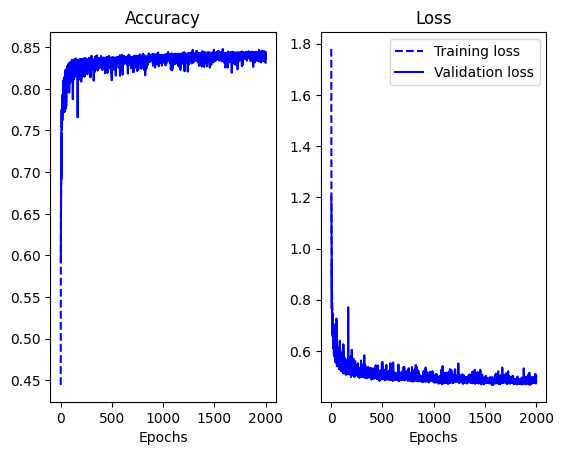

In [ ]:
# Plotting the accuracy and loss values for both the training and validation sets
fig, (ax1,ax2) = plt.subplots(1,2)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
ax1.plot(epochs, accuracy, 'b--', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax2.plot(epochs, loss, 'b--', label='Training loss')
ax2.plot(epochs, val_loss, 'b',label='Validation loss')
ax1.set_title('Accuracy')
ax2.set_title('Loss')
ax1.set_xlabel('Epochs')

ax2.set_xlabel('Epochs')

plt.legend()
plt.show()

In [12]:
# Un-doing the normalization in order to visualize the images
test_dataset = test_ds_norm.map(lambda x, y: (255*x, y))

In [13]:
# Getting the images (x_test) and true categories (y_true) from test data set
y_true = []
x_test = []
for x, y in test_dataset:
    y = y.numpy()
    y_true.append(y)
    x_test.append(x)

In [14]:
# Unpacking nested list into 1-D list
y_true = [item for sublist in y_true for item in sublist]

In [17]:
# Unpacking nested list into 1-D list
x_test = [item for sublist in x_test for item in sublist]

In [19]:
y_pred = model.predict(
    test_ds_norm,
    batch_size=None,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

59/59 [==============================] - 15s 228ms/step


In [20]:
y_pred = y_pred.argmax(axis=1)

In [22]:
label_dict = {0:'blouse', 1:'dhoti_pants', 2:'dupattas', 3:'gowns', 4:'kurta_men', 5:'leggings_and_salwars', 6:'lehenga',
          7:'mojaris_men', 8:'mojaris_women', 9:'nehru_jackets', 10:'palazzos', 11:'petticoats', 12:'sherwanis', 13:'saree',
           14:'women_kurta'}

In [23]:
def tensor_to_image(tensor):
    tensor = np.array(tensor, dtype=np.uint8)
    tensor = np.squeeze(tensor, axis=2)
    return Image.fromarray(tensor)

True label: blouse. Predicted label: blouse


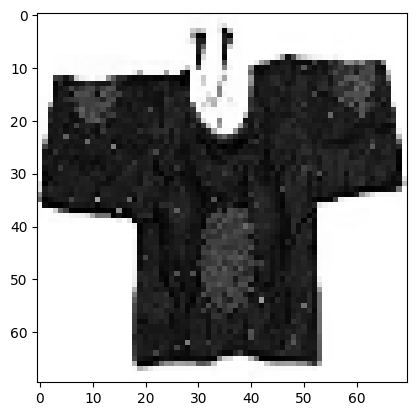

In [25]:
img = tensor_to_image(x_test[1])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1]]}. Predicted label: {label_dict[y_pred[1]]}')


True label: sherwanis. Predicted label: sherwanis


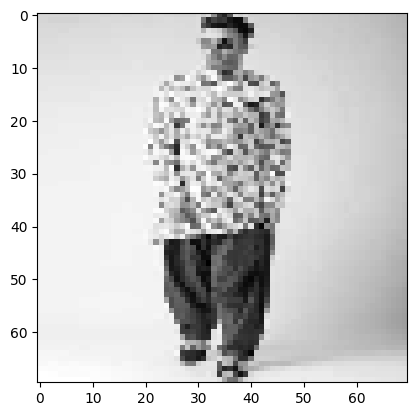

In [26]:
img = tensor_to_image(x_test[6500])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[6500]]}. Predicted label: {label_dict[y_pred[6500]]}')

True label: dupattas. Predicted label: women_kurta


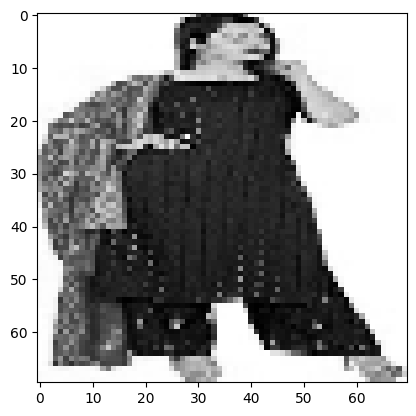

In [27]:
img = tensor_to_image(x_test[1120])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1120]]}. Predicted label: {label_dict[y_pred[1120]]}')

## In the above picture, the women is also wearing a dupatta.

True label: dupattas. Predicted label: dupattas


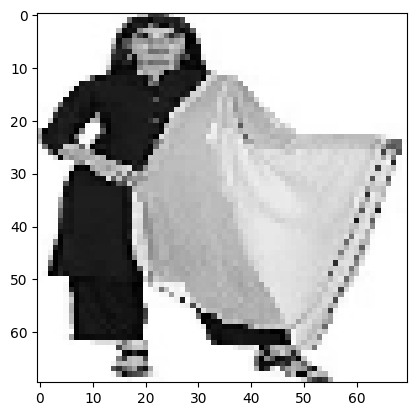

In [28]:
img = tensor_to_image(x_test[1300])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[1300]]}. Predicted label: {label_dict[y_pred[1300]]}')

True label: women_kurta. Predicted label: women_kurta


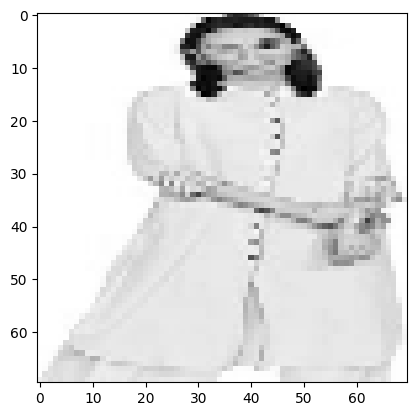

In [29]:
img = tensor_to_image(x_test[7000])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[7000]]}. Predicted label: {label_dict[y_pred[7000]]}')


True label: saree. Predicted label: saree


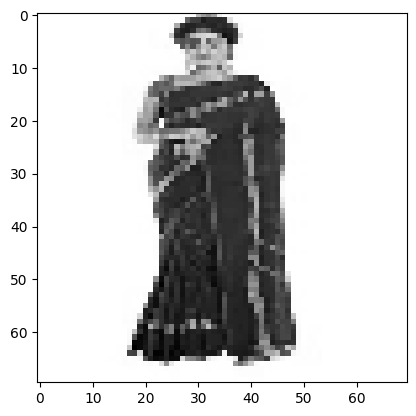

In [30]:
img = tensor_to_image(x_test[6000])
plt.imshow(img, cmap='gray')
print(f'True label: {label_dict[y_true[6000]]}. Predicted label: {label_dict[y_pred[6000]]}')

In [31]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[478,   0,   6,   0,   1,   0,   0,   0,   4,   1,   1,   3,   0,
          5,   1],
       [  4, 311,   9,   2,  11,  68,   1,   2,   1,   1,  10,   9,   3,
          5,  63],
       [  2,   0, 343,   9,   0,  21,  10,   0,   2,   0,   0,   3,   1,
         20,  89],
       [  1,   2,  18, 285,   2,   1,  14,   0,   0,   1,   2,   3,   0,
         16, 155],
       [  0,   4,   1,   0, 469,   0,   1,   0,   0,   7,   0,   0,  13,
          1,   4],
       [  0,  14,   8,   1,   0, 440,   0,   0,   1,   0,  30,   3,   0,
          1,   2],
       [  1,   0,   2,  19,   0,   0, 473,   0,   0,   0,   1,   1,   0,
          1,   2],
       [  1,   1,   3,   1,   0,   0,   2, 412,  76,   0,   0,   0,   0,
          4,   0],
       [  2,   0,   3,   0,   1,   2,   0,  46, 442,   0,   1,   0,   0,
          3,   0],
       [  1,   0,   3,   0,  15,   0,   0,   0,   0, 471,   2,   1,   5,
          2,   0],
       [  0,   2,   2,   1,   0,  54,   9,   0,   0,   0, 424,   4,   0,
       

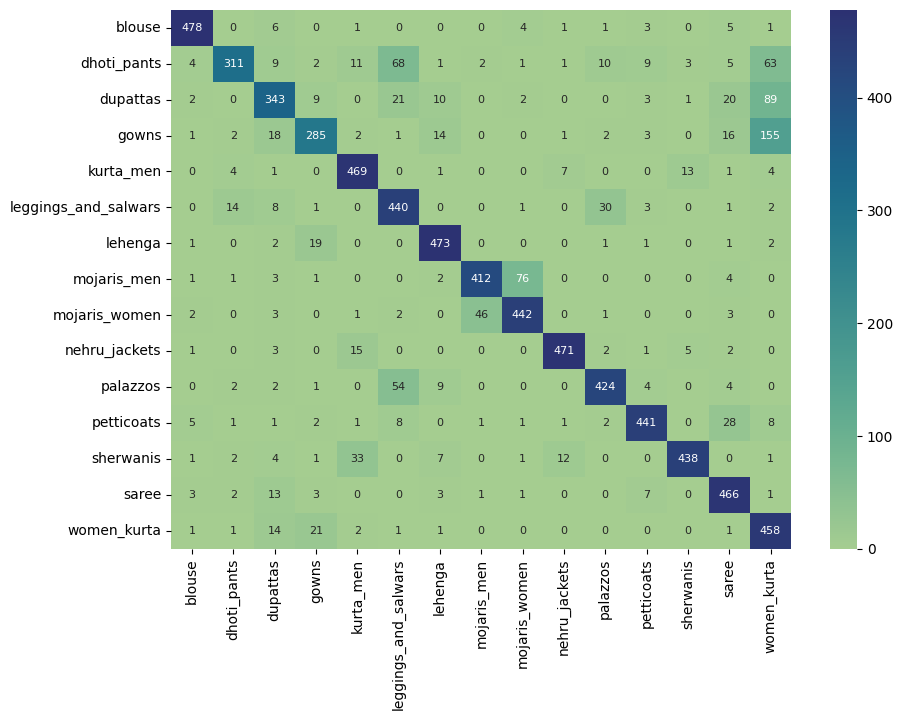

In [32]:
df_cm = pd.DataFrame(cm, index = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta'],
                  columns = ['blouse', 'dhoti_pants', 'dupattas', 'gowns', 'kurta_men', 'leggings_and_salwars', 'lehenga', 'mojaris_men', 'mojaris_women', 'nehru_jackets', 'palazzos', 'petticoats', 'sherwanis', 'saree', 'women_kurta'])
plt.figure(figsize = (10,7))
_ = sns.heatmap(df_cm, annot=True, annot_kws={"size":8}, fmt='d', cmap='crest')

## The biggest confusion of the model for the test data is between gowns and women's kurtas.